In [1]:
%load_ext autoreload
%autoreload 2

import torch
import copy
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
#from visualization.visual import *

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Set device and random seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Configuration
class Config:
    dataset_name = "wikitext-2-raw-v1"
    model_name = "distilgpt2"
    max_length = 128
    num_workers = 8
    pin_memory = True
    min_text_length = 50  # Minimum characters for a text to be included

config = Config()

In [4]:
# Load and preprocess dataset
def load_and_preprocess_data():
    dataset = load_dataset("wikitext", config.dataset_name)
    
    # Preprocessing function
    def preprocess(examples):
        texts = [text.strip() for text in examples["text"] 
                if len(text.strip()) > config.min_text_length 
                and not text.strip().startswith("=")]
        return {"text": texts}
    
    dataset = dataset.map(preprocess, batched=True)
    train_texts = dataset["train"]["text"][:1000]
    val_texts = dataset["validation"]["text"][:100]
    test_texts = dataset["test"]["text"][:100]
    
    return train_texts, val_texts, test_texts

In [5]:
# Tokenizer setup
tokenizer = GPT2Tokenizer.from_pretrained(config.model_name)

# Add padding token if not already present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

vocab_size = len(tokenizer)

In [6]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def shuffle(self):
        np.random.shuffle(self.texts)
        
    def sort_by_length(self):
        self.texts.sort(key=lambda x: len(x))
        
    def __getitem__(self, idx):
        text = self.texts[idx]

        # Create encoding
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return encoding.input_ids.squeeze()
    

In [7]:
# Model setup
def get_model():
    model = GPT2LMHeadModel.from_pretrained(config.model_name)
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)
    return model

In [8]:
from torch.cuda.amp import autocast

@torch.no_grad()
def compute_loss_(model, dataloader, device, loss_fn=None, return_perplexity=True, max_batches=None):
    """
    Compute the average loss of the model.
    Args:
        model: The model to evaluate. (e.g., DistilGPT2)
        dataloader: DataLoader for the dataset.
        loss_fn: Loss function to use. If None, the model's loss will be used.
        device: Device to perform computations on. ('cuda' or 'cpu')
        return_perplexity: If True, return perplexity as well.
        max_batches: Maximum number of batches to evaluate. If None, evaluate all batches.
    Returns:
        average_loss: The average loss of the model.
        perplexity: The perplexity of the model (if return_perplexity is True).
    """
    model.eval()

    # Initialize total loss and tokens
    total_loss = 0.0
    total_tokens = 0

    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", leave=False)):
        # Check if max_batches is reached
        if max_batches is not None and i >= max_batches:
            break

        # Unpack batch
        if isinstance(batch, (list, tuple)):
            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device) if len(batch) > 1 else None
        else:
            inputs = batch.to(device)
            attention_mask = None

        with autocast(enabled=True, dtype=torch.float16):
            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask, labels=inputs)
    
            if loss_fn is not None:
                logits = outputs.logits
                loss = loss_fn(logits.view(-1, logits.size(-1)), inputs.view(-1))
            else:
                loss = outputs.loss

        # Accumulate total loss and tokens
        if attention_mask is not None:
            num_tokens = attention_mask.sum().item()
        else:
            num_tokens = inputs.numel()

        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens

    # Avoid division by zero
    if total_tokens == 0:
        return float('nan'), float('nan') if return_perplexity else float('nan')

    avg_loss = total_loss / total_tokens

    # Calculate perplexity if required
    if return_perplexity:
        perplexity = torch.exp(torch.tensor(avg_loss)).item()
        return avg_loss, perplexity
    else:
        return avg_loss

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch
import os

# Directory to save plots
def ensure_plot_dir(dir_path="./exp_plots"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

PLOT_DIR = ensure_plot_dir()


def flatten_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])


def set_flat_params(model, flat_params):
    idx = 0
    for param in model.parameters():
        numel = param.data.numel()
        param.data.copy_(flat_params[idx:idx + numel].view_as(param.data))
        idx += numel


def generate_orthogonal_directions(model):
    theta = flatten_params(model)
    dim = theta.shape[0]

    a = torch.randn(dim)
    b = torch.randn(dim)

    b = b - torch.dot(a, b) / torch.dot(a, a) * a

    a = a / torch.norm(a)
    b = b / torch.norm(b)

    return a, b


def visual_Segment(init_model, final_model, n, loss_fn, val_loader, save_path=None):
    """
    Plots the loss along the linear interpolation between init_model and final_model.
    If save_path is provided, saves the plot to that path (otherwise defaults to 'plots/segment_loss.png').
    """
    plt.figure()
    alphas = np.linspace(-0.5, 1.5, n + 1)
    losses = []

    theta_0 = flatten_params(init_model)
    theta_f = flatten_params(final_model)
    currModel = copy.deepcopy(init_model)
    
    for alpha in alphas:
        theta = theta_0 + alpha * (theta_f - theta_0)
        set_flat_params(currModel, theta)

        loss, perp = loss_fn(currModel, val_loader, device)
        losses.append(loss)

    plt.plot(alphas, losses)
    plt.xlabel('Interpolation Factor')
    plt.ylabel('Loss')
    plt.title(r'Loss Along Interpolation Between $\theta_0$ and $\theta_f$')
    plt.grid(True)

    # Save the plot
    if save_path is None:
        save_path = os.path.join(PLOT_DIR, 'segment_loss.png')
    else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")

    plt.show()
    plt.close()
    

def visual_2D(model, a, b, loss_fn, val_loader, n=50, range_val=1.0, save_path=None):
    """
    Computes and plots a 2D loss surface in directions a and b.
    If save_path is provided, saves the contour plot (otherwise defaults to 'plots/loss_surface_2d.png').
    """
    alphas = np.linspace(-range_val, range_val, n)
    betas = np.linspace(-range_val, range_val, n)
    loss_grid = np.zeros((n, n))

    device = next(model.parameters()).device

    # Ensure a, b are on same device as model
    a = a.to(device)
    b = b.to(device)

    theta_0 = flatten_params(model).to(device)
    currModel = copy.deepcopy(model).to(device)

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            theta = theta_0 + alpha * a + beta * b
            set_flat_params(currModel, theta)
            currModel.to(device)

            loss, _ = loss_fn(currModel, val_loader, device)
            loss_grid[i, j] = loss

    A, B = np.meshgrid(alphas, betas)
    plt.figure(figsize=(8, 6))
    # Filled contour plot
    cp = plt.contourf(A, B, loss_grid.T, levels=50)
    # Add contour lines
    lines = plt.contour(A, B, loss_grid.T, levels=20, colors='black', linewidths=0.5)
    plt.clabel(lines, inline=True, fontsize=8)
    cbar = plt.colorbar(cp)
    cbar.set_label('Loss')
    plt.xlabel(r'Direction $\alpha$')
    plt.ylabel(r'Direction $\beta$')
    plt.title('Loss Surface Contours')
    # plt.grid(True)
    plt.tight_layout()

    # Save the plot
    if save_path is None:
        save_path = os.path.join(PLOT_DIR, 'loss_surface_2d.png')
    else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")

    plt.show()
    plt.close()

def flatten_vector_list(vector_list):
    return torch.cat([v.view(-1) for v in vector_list])

def generate_filter_normalized_vectors(model):
    params = list(model.parameters())
    a = [torch.randn_like(param) for param in params]
    b = [torch.randn_like(param) for param in params]
    eps = 1e-10

    for i in range(len(params)):
        model_norm = params[i].norm()
        direction_a_norm = a[i].norm()
        direction_b_norm = b[i].norm()
        a[i] = a[i] * (model_norm / (eps + direction_a_norm))
        b[i] = b[i] * (model_norm / (eps + direction_b_norm))

    # make b orthogonal to a
    for i in range(len(params)):
        a_flat = a[i].view(-1)
        b_flat = b[i].view(-1)
        proj = (torch.dot(b_flat, a_flat) / (a_flat.norm()**2 + eps)) * a[i]
        b[i] = b[i] - proj

    a_flat = flatten_vector_list(a)
    b_flat = flatten_vector_list(b)

    return a_flat, b_flat


In [10]:
def train_epoch(model, dataloader, optimizer, device, shuffle_mode='random'):
    """
    Train the model for one epoch.
    Args:
        model: The model to train.
        dataloader: DataLoader for the dataset.
        optimizer: Optimizer for the model.
        device: Device to perform computations on. ('cuda' or 'cpu')
        shuffle_mode: Mode for shuffling data. ('random', 'sorted', or None)
    Returns:
        avg_loss: The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize total loss and total tokens
    total_loss = 0.0
    total_tokens = 0

    if shuffle_mode == 'random':
        dataloader.dataset.shuffle()
    elif shuffle_mode == 'sorted':
        dataloader.dataset.sort_by_length()

    for batch in tqdm(dataloader, desc="Training", leave=False):
        # Batch is input_ids (or (input_ids, attention_mask))
        if isinstance(batch, (list, tuple)):
            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device) if len(batch) > 1 else None
        else:
            inputs = batch.to(device)
            attention_mask = None

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=str(device), enabled = True, dtype=torch.float16):
            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask, labels=inputs)
            
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Multiply by number of tokens
        total_loss += loss.item() * inputs.numel()

        # Count tokens
        total_tokens += inputs.numel()

    # Compute average loss as total loss divided by total tokens
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('nan')
    return avg_loss

In [11]:
# Experiment runner
def run_experiment(optimizer_class, lr, weight_decay, batch_size, epochs=2, shuffle_mode='random'):
    # Load data
    train_texts, val_texts, _ = load_and_preprocess_data()
    
    # Create datasets
    train_dataset = TextDataset(train_texts, tokenizer, config.max_length)
    val_dataset = TextDataset(val_texts, tokenizer, config.max_length)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    # Initialize model
    model = get_model()
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device, shuffle_mode)
        val_loss, val_perplexity = compute_loss_(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.2f}")
    
    

    results = {
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_perplexity': val_perplexity,
        'optimizer': optimizer_class.__name__,
        'lr': lr,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'shuffle_mode': shuffle_mode,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses
    }
    
    return results, model

In [12]:
def plot_loss_curves(results_list, save_path=None, fname=None):
    plt.figure(figsize=(12, 6))

    for results in results_list:
        label = f"{results['optimizer']}, lr={results['lr']}, wd={results['weight_decay']}, bs={results['batch_size']}"
        plt.plot(results['train_loss_history'], label=f"Train - {label}")
        plt.plot(results['val_loss_history'], '--', label=f"Val - {label}")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid()

    if save_path is not None and fname is not None:
        os.makedirs(save_path, exist_ok=True)
        file_name = os.path.join(save_path, f"loss_curves_{fname}.png")
        plt.savefig(file_name)
        print(f"Plot saved to: {file_name}")

    plt.show()
    plt.close()

In [13]:
def create_loaders():
    # Load data
    train_texts, val_texts, test_texts = load_and_preprocess_data()
    
    # Create datasets
    val_dataset = TextDataset(val_texts, tokenizer, config.max_length)
    
    # Create dataloaders
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )

    train_dataset = TextDataset(train_texts, tokenizer, config.max_length)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    return train_loader, val_loader

In [14]:
# Experiment runner
def plot_experiment(model_sb, model_lb, val_loader, paths: np.array):

    assert len(paths)==3
    
    # Initialize models
    nn = 100
    visual_Segment(model_sb, model_lb, nn, compute_loss_, val_loader, save_path=paths[0])

    a, b = generate_filter_normalized_vectors(model_sb)
    visual_2D(model_sb, a, b, compute_loss_, val_loader, n=4, save_path=paths[1])

    c, d = generate_filter_normalized_vectors(model_lb)
    visual_2D(model_lb, c, d, compute_loss_, val_loader, n=4, save_path=paths[2])

    return

In [15]:
from sharpness.sharpness import *
def calc_sharpness(model, train_loader, val_loader):

    hv_norm, v = power_iteration_hessian(model, train_loader, device)
    sharpenss, _ = compute_epsilon_hessian_sharpness(model, train_loader, None, v, device=device)
    check_res = check_sharpness_approximation(model, train_loader, v, hv_norm, device=device)
    return sharpenss, hv_norm


Running experiment with SGD, lr=0.001, bs=4, shuffle=random


Epoch 1/60 - Train Loss: 5.1404, Val Loss: 6.6580, Val Perplexity: 778.99


Epoch 2/60 - Train Loss: 5.2037, Val Loss: 3.4622, Val Perplexity: 31.89


Epoch 3/60 - Train Loss: 4.9499, Val Loss: 4.5981, Val Perplexity: 99.30


Epoch 4/60 - Train Loss: 4.5824, Val Loss: 3.7740, Val Perplexity: 43.55


Epoch 5/60 - Train Loss: 4.4370, Val Loss: 3.7770, Val Perplexity: 43.68


Epoch 6/60 - Train Loss: 4.3437, Val Loss: 3.6070, Val Perplexity: 36.86


Epoch 7/60 - Train Loss: 4.2898, Val Loss: 4.0492, Val Perplexity: 57.35


Epoch 8/60 - Train Loss: 4.2216, Val Loss: 4.6722, Val Perplexity: 106.93


Epoch 9/60 - Train Loss: 4.2029, Val Loss: 3.5097, Val Perplexity: 33.44


Epoch 10/60 - Train Loss: 4.1020, Val Loss: 3.2939, Val Perplexity: 26.95


Epoch 11/60 - Train Loss: 4.0421, Val Loss: 3.6461, Val Perplexity: 38.32


Epoch 12/60 - Train Loss: 4.2443, Val Loss: 3.9426, Val Perplexity: 51.55


Epoch 13/60 - Train Loss: 4.0205, Val Loss: 3.9370, Val Perplexity: 51.27


Epoch 14/60 - Train Loss: 3.9812, Val Loss: 3.5973, Val Perplexity: 36.50


Epoch 15/60 - Train Loss: 4.0390, Val Loss: 3.5689, Val Perplexity: 35.48


Epoch 16/60 - Train Loss: 3.9400, Val Loss: 3.3183, Val Perplexity: 27.61


Epoch 17/60 - Train Loss: 3.9553, Val Loss: 3.2643, Val Perplexity: 26.16


Epoch 18/60 - Train Loss: 3.9036, Val Loss: 4.8722, Val Perplexity: 130.61


Epoch 19/60 - Train Loss: 3.9102, Val Loss: 3.3514, Val Perplexity: 28.54


Epoch 20/60 - Train Loss: 4.0324, Val Loss: 3.4737, Val Perplexity: 32.26


Epoch 21/60 - Train Loss: 3.8671, Val Loss: 3.5124, Val Perplexity: 33.53


Epoch 22/60 - Train Loss: 3.7912, Val Loss: 3.2415, Val Perplexity: 25.57


Epoch 23/60 - Train Loss: 3.8131, Val Loss: 3.4147, Val Perplexity: 30.41


Epoch 24/60 - Train Loss: 3.7879, Val Loss: 4.0050, Val Perplexity: 54.87


Epoch 25/60 - Train Loss: 3.7256, Val Loss: 3.5935, Val Perplexity: 36.36


Epoch 26/60 - Train Loss: 3.8181, Val Loss: 3.6562, Val Perplexity: 38.72


Epoch 27/60 - Train Loss: 3.7786, Val Loss: 3.9451, Val Perplexity: 51.68


Epoch 28/60 - Train Loss: 3.8388, Val Loss: 3.8061, Val Perplexity: 44.97


Epoch 29/60 - Train Loss: 3.8398, Val Loss: 3.3910, Val Perplexity: 29.70


Epoch 30/60 - Train Loss: 3.7262, Val Loss: 3.4609, Val Perplexity: 31.85


Epoch 31/60 - Train Loss: 3.7019, Val Loss: 3.9678, Val Perplexity: 52.87


Epoch 32/60 - Train Loss: 3.7012, Val Loss: 3.7704, Val Perplexity: 43.40


Epoch 33/60 - Train Loss: 3.6990, Val Loss: 3.5113, Val Perplexity: 33.49


Epoch 34/60 - Train Loss: 3.6884, Val Loss: 3.4041, Val Perplexity: 30.09


Epoch 35/60 - Train Loss: 3.7040, Val Loss: 3.4290, Val Perplexity: 30.84


Epoch 36/60 - Train Loss: 3.6576, Val Loss: 3.4238, Val Perplexity: 30.69


Epoch 37/60 - Train Loss: 3.6957, Val Loss: 3.3730, Val Perplexity: 29.16


Epoch 38/60 - Train Loss: 3.6411, Val Loss: 3.5870, Val Perplexity: 36.12


Epoch 39/60 - Train Loss: 3.6827, Val Loss: 3.4934, Val Perplexity: 32.90


Epoch 40/60 - Train Loss: 3.6499, Val Loss: 3.7727, Val Perplexity: 43.50


Epoch 41/60 - Train Loss: 3.6460, Val Loss: 4.2934, Val Perplexity: 73.22


Epoch 42/60 - Train Loss: 3.6216, Val Loss: 3.5598, Val Perplexity: 35.16


Epoch 43/60 - Train Loss: 3.6203, Val Loss: 3.5183, Val Perplexity: 33.73


Epoch 44/60 - Train Loss: 3.5730, Val Loss: 3.4243, Val Perplexity: 30.70


Epoch 45/60 - Train Loss: 3.6343, Val Loss: 3.4438, Val Perplexity: 31.30


Epoch 46/60 - Train Loss: 3.5466, Val Loss: 4.1104, Val Perplexity: 60.97


Epoch 47/60 - Train Loss: 3.5770, Val Loss: 3.3161, Val Perplexity: 27.55


Epoch 48/60 - Train Loss: 3.5905, Val Loss: 3.7360, Val Perplexity: 41.93


Epoch 49/60 - Train Loss: 3.5915, Val Loss: 3.4947, Val Perplexity: 32.94


Epoch 50/60 - Train Loss: 3.5667, Val Loss: 3.4508, Val Perplexity: 31.53


Epoch 51/60 - Train Loss: 3.5713, Val Loss: 3.4540, Val Perplexity: 31.63


Epoch 52/60 - Train Loss: 3.6097, Val Loss: 4.0363, Val Perplexity: 56.62


Epoch 53/60 - Train Loss: 3.5781, Val Loss: 3.3967, Val Perplexity: 29.87


Epoch 54/60 - Train Loss: 3.5385, Val Loss: 3.7850, Val Perplexity: 44.03


Epoch 55/60 - Train Loss: 3.5167, Val Loss: 3.3277, Val Perplexity: 27.87


Epoch 56/60 - Train Loss: 3.5373, Val Loss: 3.5503, Val Perplexity: 34.82


Epoch 57/60 - Train Loss: 3.5248, Val Loss: 3.3777, Val Perplexity: 29.30


Epoch 58/60 - Train Loss: 3.4910, Val Loss: 3.3367, Val Perplexity: 28.13


Epoch 59/60 - Train Loss: 3.5348, Val Loss: 3.3258, Val Perplexity: 27.82


Epoch 60/60 - Train Loss: 3.4976, Val Loss: 3.3236, Val Perplexity: 27.76
Plot saved to: exp_plots/loss_curves_SGD_0.001_4_random_0.0005.png


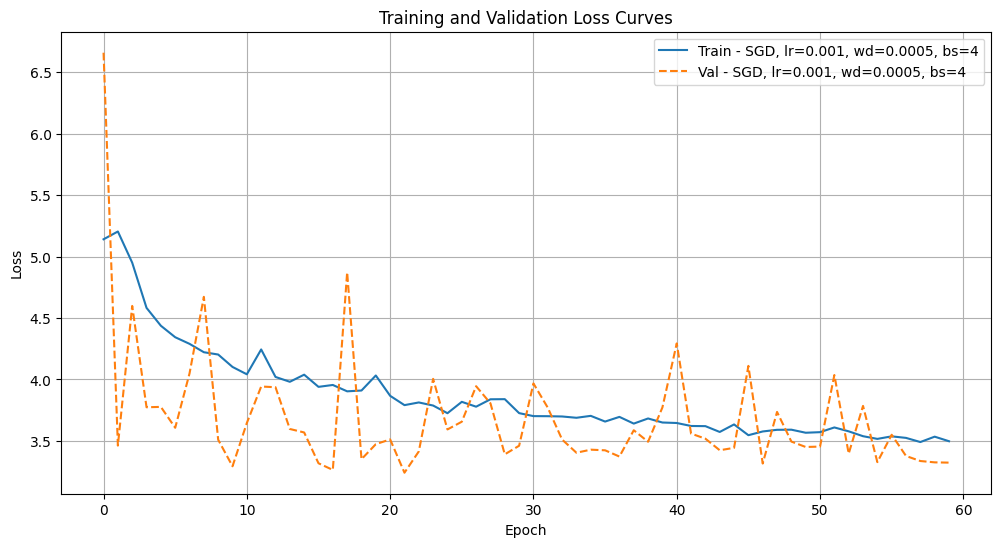


Experiment Summary:

Optimizer: SGD
LR: 0.001, Shuffle: random, Batch Size: 4, Weight Decay: 0.0005
Final Train Loss: 3.4976, Val Loss: 3.3236


In [18]:
import os
import torch

# Main experiment
!export CUDA_VISIBLE_DEVICES=3

EPOCHS = 60
def main():

    LR = 0.001
    BS = 4
    SHUFFLE = "random"
    WD = 0.0005
    
    # Define experiments to run
    torch.cuda.empty_cache()
    experiments = [
        #{'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'random', 'weight_decay': 0.0005},
        {'optimizer_class': torch.optim.SGD,  'lr': LR, 'batch_size': BS, 'shuffle_mode': SHUFFLE, 'weight_decay': WD},
        # {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'sorted'},
        # {'optimizer_class': torch.optim.Adam, 'lr': 0.001, 'batch_size': 8, 'shuffle_mode': 'random'},
        # {'optimizer_class': torch.optim.Adam, 'lr': 0.001, 'batch_size': 8, 'shuffle_mode': 'sorted'},
        # {'optimizer_class': torch.optim.AdamW, 'lr': 0.0001, 'batch_size': 8, 'shuffle_mode': 'random'},
    ]
    
    results_list = []
    models_list = []
    
    # Create the results directory if it doesn't exist
    os.makedirs("exp_results", exist_ok=True)
    
    for exp in experiments:
        print(f"\nRunning experiment with {exp['optimizer_class'].__name__}, lr={exp['lr']}, bs={exp['batch_size']}, shuffle={exp['shuffle_mode']}")
        
        results, model = run_experiment(
            optimizer_class=exp['optimizer_class'],
            lr=exp['lr'],
            weight_decay=exp['weight_decay'],
            batch_size=exp['batch_size'],
            epochs=EPOCHS,
            shuffle_mode=exp['shuffle_mode'],
        )
        
        results_list.append(results)
        models_list.append(model)
    
        # Generate a consistent filename
        fname = f"{exp['optimizer_class'].__name__}_{exp['lr']}_{exp['batch_size']}_{exp['shuffle_mode']}_{exp['weight_decay']}"
    
        # Save model state dict
        torch.save(model.state_dict(), f"exp_results/model_params_{fname}.pt")
    
        # Save results dict
        torch.save(results, f"exp_results/results_{fname}.pt")
        
    # Save results
    torch.save(results_list, 'experiment_results.pt')
    
    # Plot loss curves with named output
    if len(experiments) == 1:
        exp = experiments[0]
        fname = f"{exp['optimizer_class'].__name__}_{exp['lr']}_{exp['batch_size']}_{exp['shuffle_mode']}_{exp['weight_decay']}"
    else:
        fname = "multiple_experiments"
    
    plot_loss_curves(results_list, save_path="exp_plots", fname=fname)
    
    # Print summary
    print("\nExperiment Summary:")
    for res in results_list:
        print(f"\nOptimizer: {res['optimizer']}")
        print(f"LR: {res['lr']}, Shuffle: {res['shuffle_mode']}, Batch Size: {res['batch_size']}, Weight Decay: {res['weight_decay']}")
        print(f"Final Train Loss: {res['train_loss']:.4f}, Val Loss: {res['val_loss']:.4f}")



if __name__ == "__main__":
    main()

Loading parameters from model_params_SGD_0.001_24_random_0.0005.pt...
Loading parameters from model_params_SGD_0.001_4_random_0.0005.pt...


Plot saved to: ./exp_plots/segment_model_params_SGD_0.001_24_random_0.0005_model_params_SGD_0.001_4_random_0.0005.png


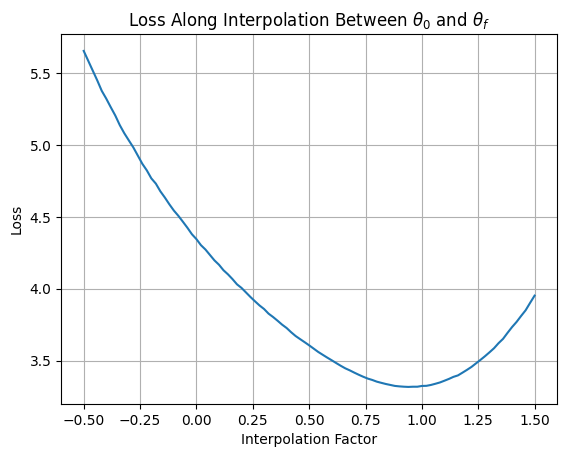

Plot saved to: ./exp_plots/2D_plot_model_params_SGD_0.001_24_random_0.0005.png


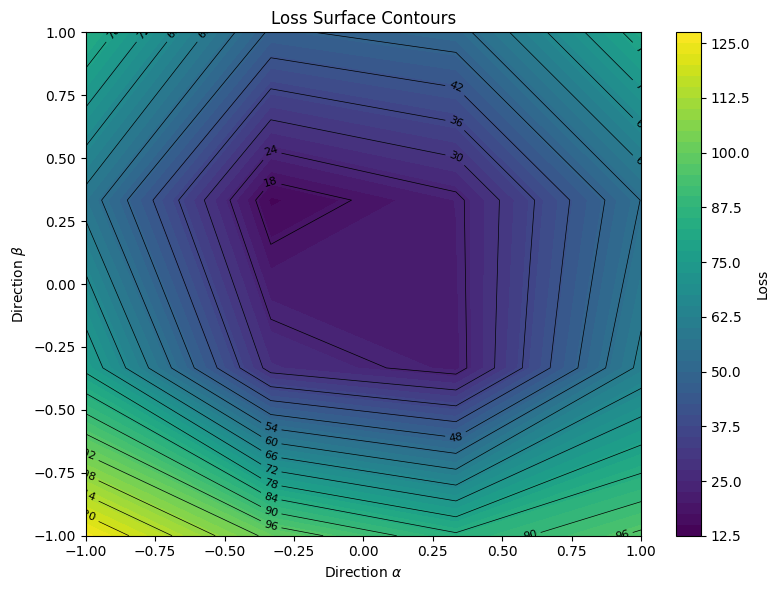

Plot saved to: ./exp_plots/2D_plot_model_params_SGD_0.001_4_random_0.0005.png


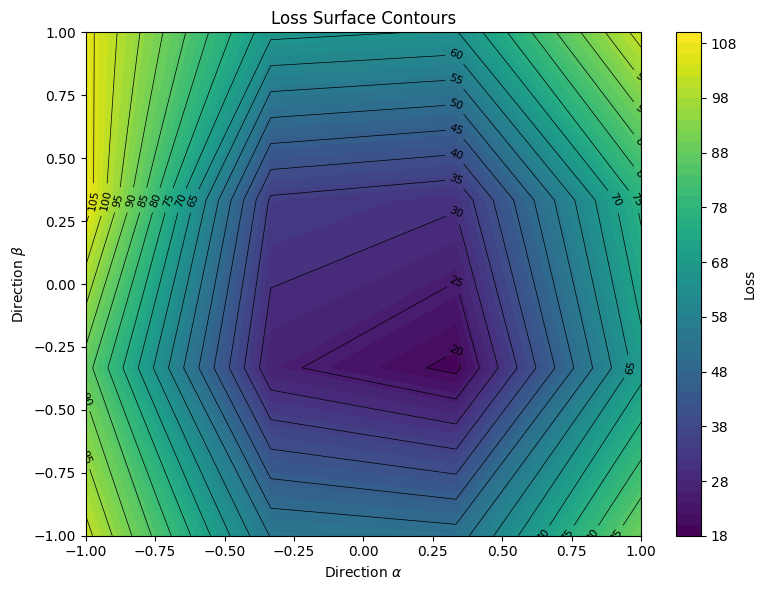

In [19]:
import os

model_name = "distilgpt2"
models_list = []
models_name = []

model_dir = "exp_results"

# Load all parameter files and wrap them into model instances
for file_name in os.listdir(model_dir):
    if file_name.startswith("model_params_") and file_name.endswith(".pt"):
        print(f"Loading parameters from {file_name}...")

        file_path = os.path.join(model_dir, file_name)
        state_dict = torch.load(file_path)
        
        model = get_model()
        model.load_state_dict(state_dict)
        model.eval()
        model = model.cuda() if torch.cuda.is_available() else model
        models_name.append(file_name)
        models_list.append(model)

# Now it's safe to use models_list
train_loader, val_loader = create_loaders() 

PATH = './exp_plots/'
paths = [PATH + f"segment_{models_name[0][:-3]}_{models_name[1][:-3]}.png",
        PATH + f"2D_plot_{models_name[0][:-3]}.png",
        PATH + f"2D_plot_{models_name[1][:-3]}.png"]
plot_experiment(models_list[0], models_list[1], val_loader, paths=paths)

In [20]:
for model in models_list:
    model.to(device)
    sharpenss, hv_norm = calc_sharpness(model, train_loader, val_loader)
    print(f"Model: {model_name}, Sharpness: {sharpenss:.4f}%, HV Norm: {hv_norm:.4f}")
    

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]              


Measured relative loss increase: 0.03%
Predicted relative loss increase: 0.03%
Linear term: 3.0260e-03
Quadratic term (0.5 * eps^2 * lambda_max): 9.2885e-06
Model: distilgpt2, Sharpness: 0.0157%, HV Norm: 18.5771


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]              


Measured relative loss increase: -0.04%
Predicted relative loss increase: -0.04%
Linear term: -4.7572e-03
Quadratic term (0.5 * eps^2 * lambda_max): 9.2588e-06
Model: distilgpt2, Sharpness: -0.0584%, HV Norm: 18.5176
